<a href="https://colab.research.google.com/github/rishrk007/-Mengary-Revenue-Prediction/blob/main/Mengary_Revenue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
#from scipy.stasts import norm, skew
import seaborn as sns
import warnings

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error as mse, mean_squared_log_error as msle, r2_score as r2
from sklearn.model_selection import cross_val_score


In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sampleSolution.csv")

In [ ]:
print(train.shape)

(6700, 16)


In [ ]:
train.isnull().sum()

id                 0
departure city     0
discount           0
price              0
no of items        0
location           0
class              0
segment            0
sub-class          0
delivery type      1
RID                0
profit             0
delivery date      0
address code       0
departure state    0
placement date     0
dtype: int64

In [ ]:
#train = train.dropna()
train = train.drop_duplicates()

In [ ]:
print(train.shape)

(6700, 16)


In [ ]:
train.head()

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.5512,2018-01-01,77095,Texas,2018-01-01
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.3650,2018-01-01,48185,Michigan,2018-01-01
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.8609,2018-01-01,48185,Michigan,2018-01-01
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.7368,2018-01-01,48185,Michigan,2018-01-01
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.9792,2018-01-01,48185,Michigan,2018-01-01


In [ ]:
cat_col = train.select_dtypes(include=['object']).columns
num_col = train.select_dtypes(exclude=['object']).columns

In [ ]:
#ax = sns.pairplot(train[num_col])

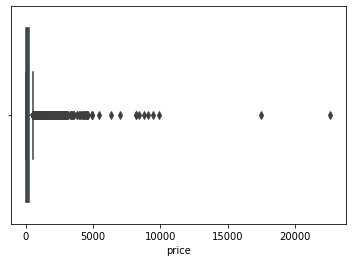

In [ ]:
sns.boxplot(x='price',data=train)

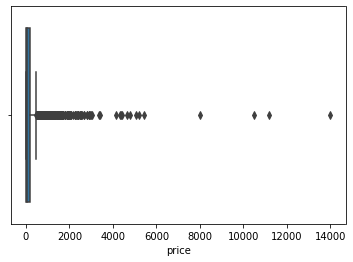

In [ ]:
sns.boxplot(x='price',data=test)

In [ ]:
#train = train.drop(train[(train['price']>15000)].index)

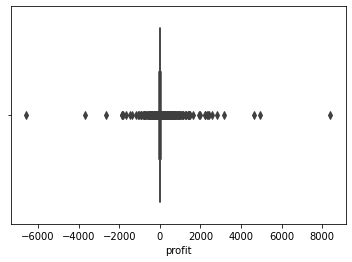

In [ ]:
sns.boxplot(x='profit',data=train)

In [ ]:
#train = train.drop(train[(train['profit']>4000)].index)
#train = train.drop(train[(train['profit']<-2000)].index)

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(standardize=False)

train['profit'] = pt.fit_transform(train['profit'].values.reshape(-1,1))

In [ ]:
# Merging Train and Test Data
df = pd.concat([train,test], ignore_index = True, sort = False)

In [ ]:
df.head()

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.475718,2018-01-01,77095,Texas,2018-01-01
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.087959,2018-01-01,48185,Michigan,2018-01-01
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.799447,2018-01-01,48185,Michigan,2018-01-01
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.478162,2018-01-01,48185,Michigan,2018-01-01
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.622493,2018-01-01,48185,Michigan,2018-01-01


In [ ]:
df.tail()

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
9989,9990,New York City,0.0,31.920,4,East,kariox,Consumer,laptop,Second Class,1171,NaN,2021-12-01,10035,New York,2021-12-01
9990,9991,New York City,0.0,19.440,3,East,kariox,Consumer,phone,Second Class,1170,NaN,2021-12-01,10035,New York,2021-12-01
9991,9992,New York City,0.0,272.940,3,East,kariox,Consumer,laptop,Second Class,1169,NaN,2021-12-01,10035,New York,2021-12-01
9992,9993,San Francisco,0.2,113.568,2,West,qexty,Consumer,tshirts,Standard Class,414,NaN,2021-12-01,94110,California,2021-12-01
9993,9994,Loveland,0.2,3.024,3,West,kariox,Consumer,lighting,Standard Class,5092,NaN,2022-01-01,80538,Colorado,2021-12-01


In [ ]:
df1 = df.groupby(['class','sub-class'])['profit'].mean()

In [ ]:
df1=df1.reset_index()
df1=df1.rename(columns={'profit':'class_mean_profit'})

df1.head()

,class,sub-class,class_mean_profit
0,fynota,chocolates,50.156322
1,fynota,colddrinks,50.146095
2,fynota,fastfood,633.724546
3,fynota,sweets,36.997740
4,kariox,battery,30.934555


In [ ]:
#df = pd.merge(df, df1,  how='left', left_on=['class','sub-class'], right_on = ['class','sub-class'])

In [ ]:
df.head()

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.475718,2018-01-01,77095,Texas,2018-01-01
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.087959,2018-01-01,48185,Michigan,2018-01-01
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.799447,2018-01-01,48185,Michigan,2018-01-01
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.478162,2018-01-01,48185,Michigan,2018-01-01
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.622493,2018-01-01,48185,Michigan,2018-01-01


In [ ]:
df['delivery type'] = df['delivery type'].fillna('Standard Class')

In [ ]:
df['discount_price'] = df['discount'] * df['price']
df['MRP'] = df['discount_price'] + df['price']

In [ ]:
pt1 = PowerTransformer()

df['price'] = pt1.fit_transform(df['price'].values.reshape(-1,1))
df['discount_price'] = pt1.fit_transform(df['discount_price'].values.reshape(-1,1))
df['MRP'] = pt1.fit_transform(df['MRP'].values.reshape(-1,1))

In [ ]:
df['delivery date'].unique()

array(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
       '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
       '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
       '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
       '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
       '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
       '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
       '2022-01-01'], dtype=object)

In [ ]:
df['placement date'] = pd.to_datetime(df['placement date'], format='%Y-%m-%d')
df['delivery date'] = pd.to_datetime(df['delivery date'],  format='%Y-%d-%m')

df['scheduleDiff'] = (df['delivery date'] - df['placement date']).map(lambda x:str(x).split()[0])
df['scheduleDiff'] = pd.to_numeric(df['scheduleDiff'])

In [ ]:
df['scheduleDiff'].unique()

array([   0,    1,  -30,  -29,  -57,  -56,  -87,  -86, -116, -115, -146,
       -145, -175, -174, -205, -204, -235, -234, -264, -263, -294, -293,
       -323,   31,  -58,  -88, -117, -147, -176, -206, -236, -265, -295,
       -324])

In [ ]:
df['location'] = df['location'].replace( {'Central':0 , 'South':1, 'West':2, 'East':3} )
df['class'] = df['class'].replace( {'kariox':0, 'qexty':1, 'fynota':2} )
df['segment'] = df['segment'].replace( {'Consumer':0, 'Corporate':1, 'Home Office':2} )
df['delivery type'] = df['delivery type'].replace( {'Standard Class':0, 'First Class':1, 'Second Class':2, 'Same Day':3} )

In [ ]:
df['sub-class'] = df['sub-class'].factorize()[0]
df['departure city'] = df['departure city'].factorize()[0]
df['departure state'] = df['departure state'].factorize()[0]
df['delivery date'] = df['delivery date'].factorize()[0]
df['placement date'] = df['placement date'].factorize()[0]

In [ ]:
df.head()

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date,discount_price,MRP,scheduleDiff
0,1,0,0.2,-0.803622,2,0,0,0,0,0,7981,5.475718,0,77095,0,0,0.307201,-0.771572,0
1,2,1,0.0,-0.414353,5,0,0,0,1,0,6334,13.087959,0,48185,1,0,-0.940982,-0.495355,0
2,3,1,0.0,-0.876980,3,0,1,0,2,0,6333,4.799447,0,48185,1,0,-0.940982,-0.972296,0
3,4,1,0.0,-0.161964,3,0,0,0,3,0,6332,12.478162,0,48185,1,0,-0.940982,-0.236822,0
4,5,1,0.0,0.100379,2,0,0,0,4,0,6331,15.622493,0,48185,1,0,-0.940982,0.030618,0


In [ ]:
df['isProfit'] = np.where(df['discount'] >= 0.2, 1, 0)

In [ ]:
temp = df.groupby(['sub-class']).agg({'discount':['count','mean','sum'],
                                      'price':['count','mean','sum'],
                                      'no of items':['count','mean','sum'],
                                      'MRP':['count','mean','sum'],
                                      'discount_price':['count','mean','sum'],
                                      'departure city':['count','nunique'],
                                      'location':['count'],
                                      'segment':['count'],
                                      'departure state':['count','nunique'],
                                      'address code':['count','nunique'],
                                      })
temp.columns = ['_'.join(x) for x in temp.columns]
df = pd.merge(df,temp,on=['sub-class'],how='left')

In [ ]:
df.head()

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date,discount_price,MRP,scheduleDiff,isProfit,discount_count,discount_mean,discount_sum,price_count,price_mean,price_sum,no of items_count,no of items_mean,no of items_sum,MRP_count,MRP_mean,MRP_sum,discount_price_count,discount_price_mean,discount_price_sum,departure city_count,departure city_nunique,location_count,segment_count,departure state_count,departure state_nunique,address code_count,address code_nunique
0,1,0,0.2,-0.803622,2,0,0,0,0,0,7981,5.475718,0,77095,0,0,0.307201,-0.771572,0,1,1370,0.074891,102.6,1370,-0.390028,-534.338589,1370,3.779562,5178,1370,-0.429595,-588.545092,1370,-0.398206,-545.542426,1370,282,1370,1370,1370,46,1370,352
1,2,1,0.0,-0.414353,5,0,0,0,1,0,6334,13.087959,0,48185,1,0,-0.940982,-0.495355,0,0,1523,0.372292,567.0,1523,-0.603040,-918.430550,1523,3.922521,5974,1523,-0.509797,-776.420527,1523,0.273387,416.368538,1523,322,1523,1523,1523,47,1523,402
2,3,1,0.0,-0.876980,3,0,1,0,2,0,6333,4.799447,0,48185,1,0,-0.940982,-0.972296,0,0,957,0.138349,132.4,957,-0.164970,-157.876244,957,3.723093,3563,957,-0.171183,-163.822395,957,-0.243853,-233.367496,957,263,957,957,957,44,957,330
3,4,1,0.0,-0.161964,3,0,0,0,3,0,6332,12.478162,0,48185,1,0,-0.940982,-0.236822,0,0,796,0.074874,59.6,796,-0.773785,-615.932775,796,3.768844,3000,796,-0.824947,-656.658005,796,-0.491936,-391.580902,796,235,796,796,796,43,796,296
4,5,1,0.0,0.100379,2,0,0,0,4,0,6331,15.622493,0,48185,1,0,-0.940982,0.030618,0,0,846,0.074704,63.2,846,0.441608,373.600109,846,3.732861,3158,846,0.411665,348.268790,846,-0.211364,-178.813819,846,228,846,846,846,44,846,282


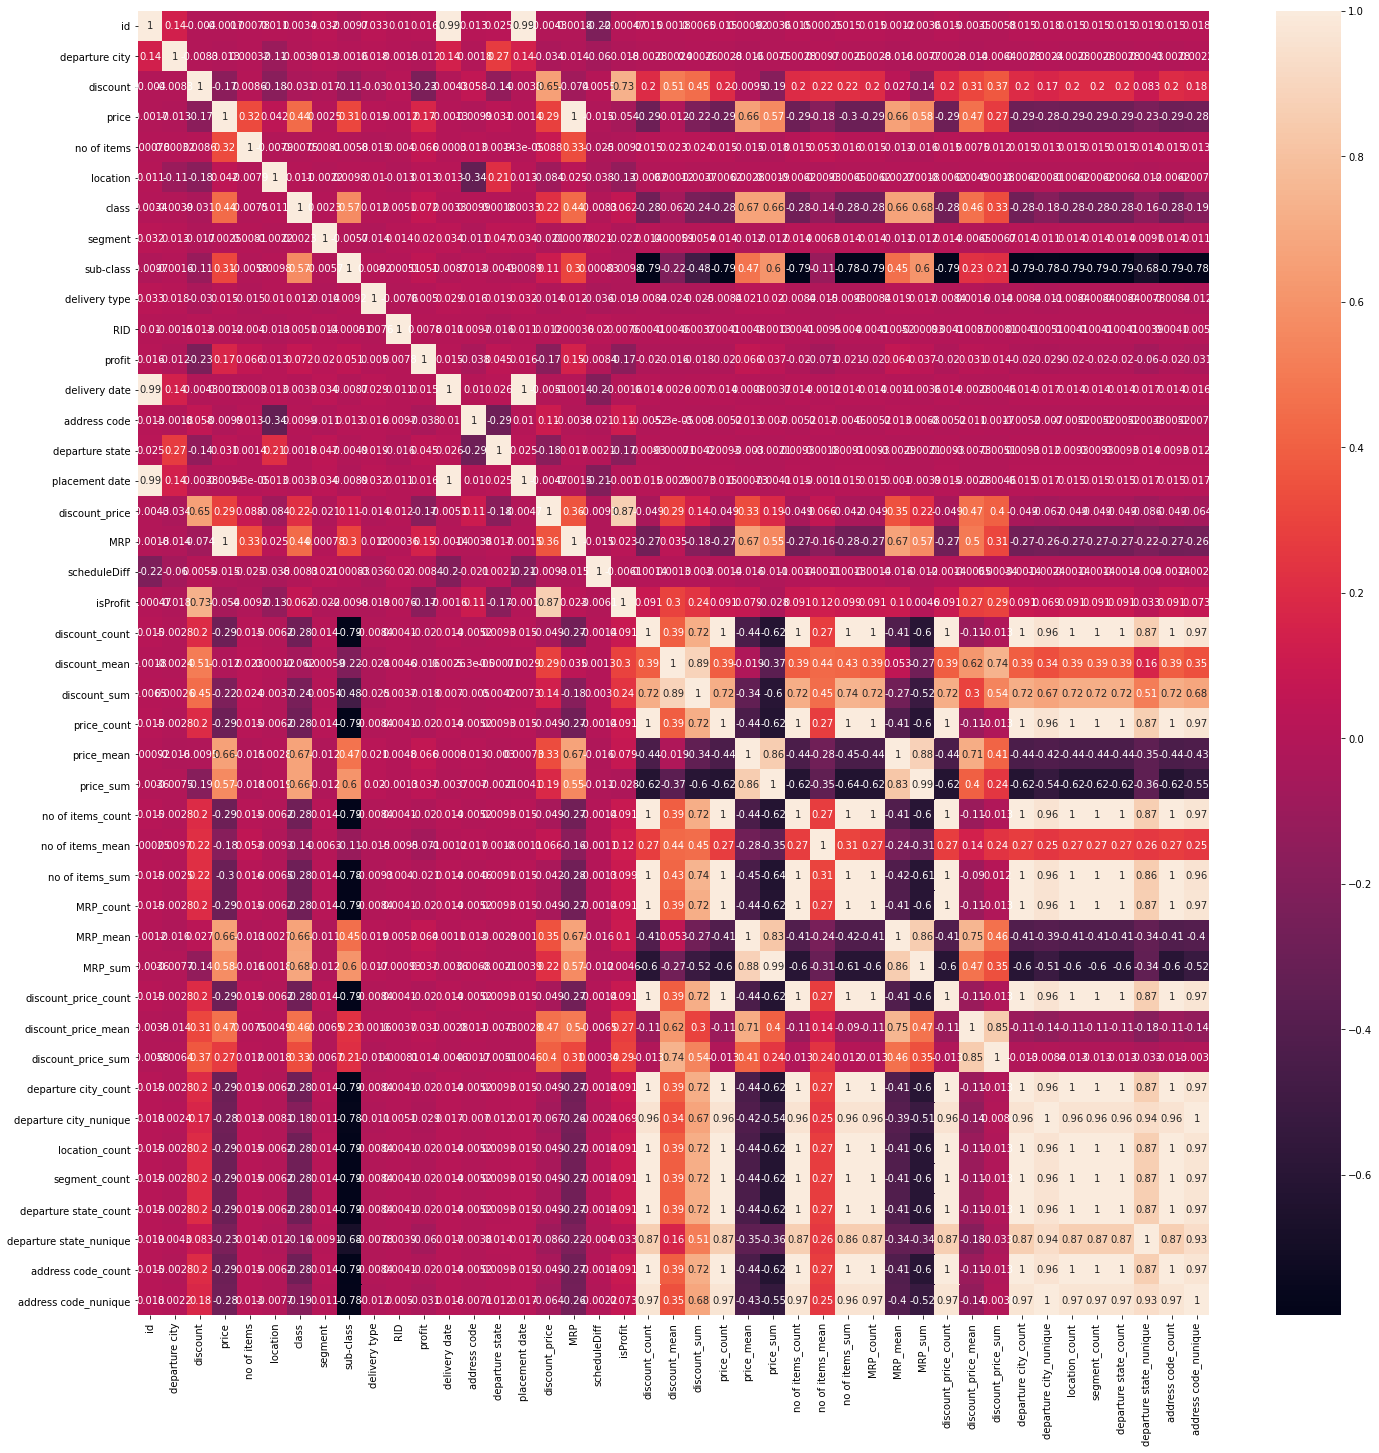

In [ ]:
import seaborn as sns
plt.subplots(figsize = (24,24))
sns.heatmap(df.corr(),annot=True)

In [ ]:
df.drop(columns=['id','RID','class'],inplace=True)

In [ ]:
Target = 'profit'

train_df = df[~df.profit.isna()]
test_df = df[df.profit.isna()]

features = [c for c in train_df.columns if c not in [Target]]

In [ ]:
print(train_df.shape, test_df.shape)

(6700, 40) (3294, 40)


In [ ]:
train_df.head()

,departure city,discount,price,no of items,location,segment,sub-class,delivery type,profit,delivery date,address code,departure state,placement date,discount_price,MRP,scheduleDiff,isProfit,discount_count,discount_mean,discount_sum,price_count,price_mean,price_sum,no of items_count,no of items_mean,no of items_sum,MRP_count,MRP_mean,MRP_sum,discount_price_count,discount_price_mean,discount_price_sum,departure city_count,departure city_nunique,location_count,segment_count,departure state_count,departure state_nunique,address code_count,address code_nunique
0,0,0.2,-0.803622,2,0,0,0,0,5.475718,0,77095,0,0,0.307201,-0.771572,0,1,1370,0.074891,102.6,1370,-0.390028,-534.338589,1370,3.779562,5178,1370,-0.429595,-588.545092,1370,-0.398206,-545.542426,1370,282,1370,1370,1370,46,1370,352
1,1,0.0,-0.414353,5,0,0,1,0,13.087959,0,48185,1,0,-0.940982,-0.495355,0,0,1523,0.372292,567.0,1523,-0.603040,-918.430550,1523,3.922521,5974,1523,-0.509797,-776.420527,1523,0.273387,416.368538,1523,322,1523,1523,1523,47,1523,402
2,1,0.0,-0.876980,3,0,0,2,0,4.799447,0,48185,1,0,-0.940982,-0.972296,0,0,957,0.138349,132.4,957,-0.164970,-157.876244,957,3.723093,3563,957,-0.171183,-163.822395,957,-0.243853,-233.367496,957,263,957,957,957,44,957,330
3,1,0.0,-0.161964,3,0,0,3,0,12.478162,0,48185,1,0,-0.940982,-0.236822,0,0,796,0.074874,59.6,796,-0.773785,-615.932775,796,3.768844,3000,796,-0.824947,-656.658005,796,-0.491936,-391.580902,796,235,796,796,796,43,796,296
4,1,0.0,0.100379,2,0,0,4,0,15.622493,0,48185,1,0,-0.940982,0.030618,0,0,846,0.074704,63.2,846,0.441608,373.600109,846,3.732861,3158,846,0.411665,348.268790,846,-0.211364,-178.813819,846,228,846,846,846,44,846,282


**Model Testing**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error,mean_absolute_error

from sklearn import metrics
def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  results = metrics.r2_score(y_true, y_pred)
  #results = 100*max(0, 1 -mean_squared_log_error(y_true, y_pred))
  return results

def av_metric1(y_true, y_pred):
  results = mean_absolute_error(y_true, y_pred)
  #results = 100*max(0, 1 -mean_squared_log_error(y_true, y_pred))
  return results*100

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler,RobustScaler

def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[Target]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[Target], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  oofs_score1 = av_metric1(target, oofs)

  print(f'\n\nAV metric for oofs is {oofs_score}')
  print(f'\n\nAV metric for oofs is {oofs_score1}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(20, 10))

  return oofs, preds,fi


**Extra Trees Classifier**


------------- Fold 1 -------------

AV metric score for validation set is 0.8145491518908216

------------- Fold 2 -------------

AV metric score for validation set is 0.9343631960179577

------------- Fold 3 -------------

AV metric score for validation set is 0.9280414407746181

------------- Fold 4 -------------

AV metric score for validation set is 0.8609378320436933

------------- Fold 5 -------------

AV metric score for validation set is 0.6306267730102845


AV metric for oofs is 0.7616004649999825


AV metric for oofs is 1856.4481503619859


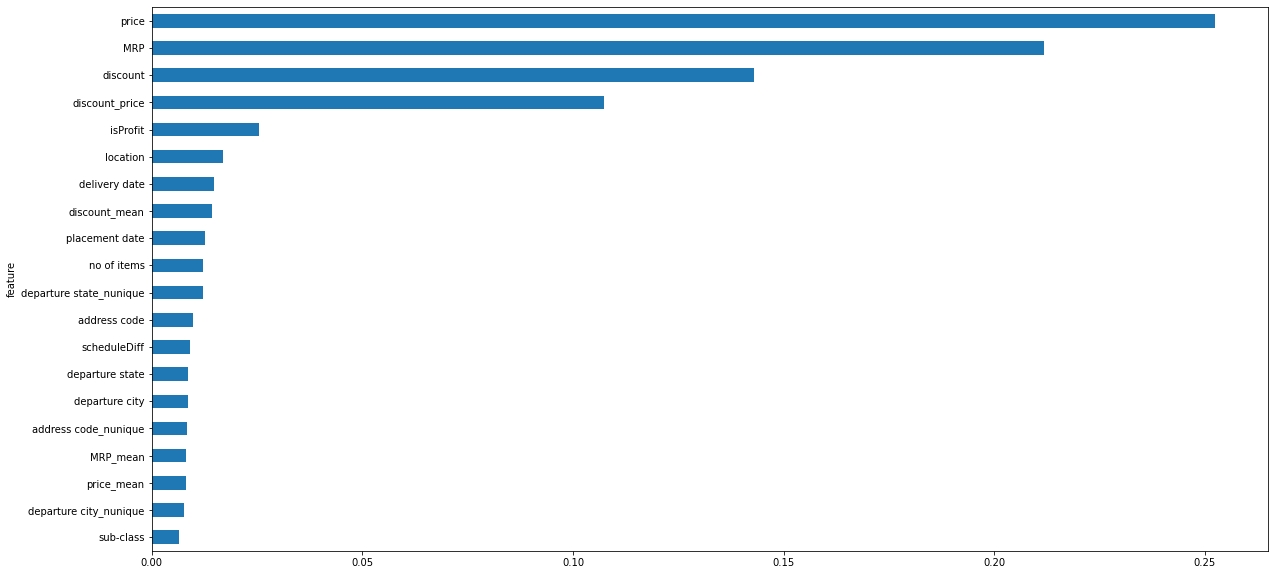

In [ ]:
clf = ExtraTreesRegressor(n_estimators =700, max_depth =100)

dtet_oofs, test_pred, feature_importance = run_clf_kfold(clf, train_df, test_df, features)

In [ ]:
test_pred

array([ 7.51058199, 37.37861066,  1.33292554, ..., 35.11725281,
        8.88389687,  0.8852877 ])


------------- Fold 1 -------------

AV metric score for validation set is 0.803749591048615

------------- Fold 2 -------------

AV metric score for validation set is 0.9276132048977851

------------- Fold 3 -------------

AV metric score for validation set is 0.9167546438800702

------------- Fold 4 -------------

AV metric score for validation set is 0.8634034111811697

------------- Fold 5 -------------

AV metric score for validation set is 0.6201557442581498


AV metric for oofs is 0.7528567872043487


AV metric for oofs is 1860.7805003246835


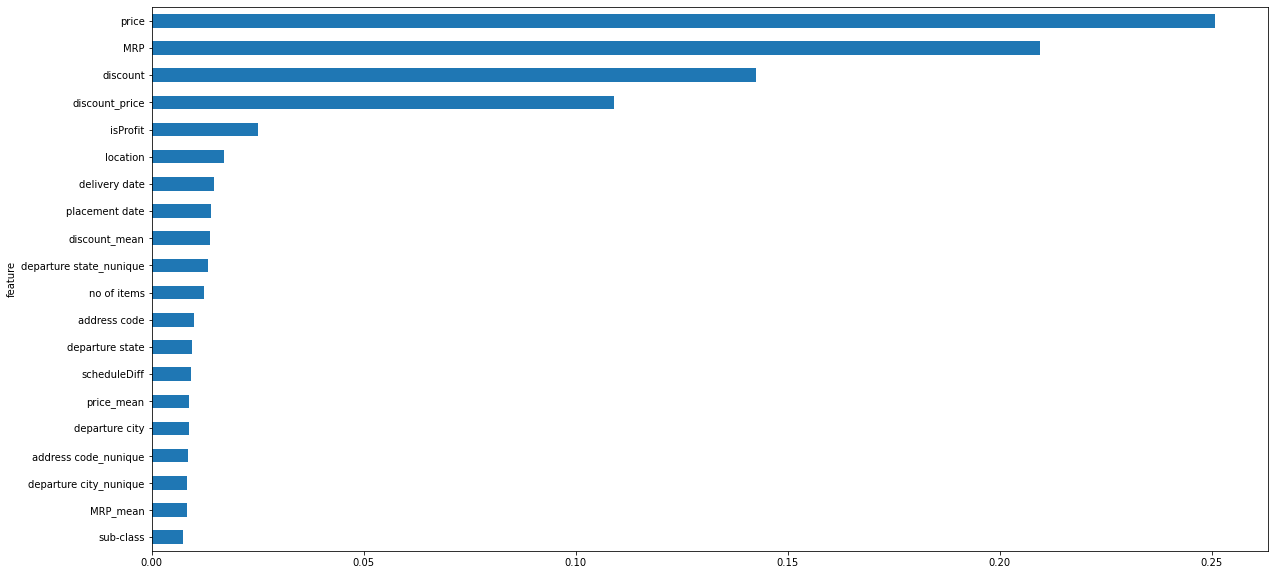

In [ ]:
clf1 = ExtraTreesRegressor(n_estimators =800, max_depth =100)

dtet_oofs, test_pred2, feature_importance = run_clf_kfold(clf1, train_df, test_df, features)

In [ ]:
test_pred2

array([ 7.51969718, 37.33741804,  1.31982635, ..., 35.12879451,
        8.9333626 ,  0.71735782])

In [ ]:
sub['profit'] = test_pred
sub['profit'] = pt.inverse_transform(sub['profit'].values.reshape(-1,1))
sub.to_csv("final.csv",index=False)

sub.head()

,id,profit
0,6701,7.632932
1,6702,38.561706
2,6703,1.340209
3,6704,3.888945
4,6705,32.097090


**XGBoost**


------------- Fold 1 -------------
[10:11:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

AV metric score for validation set is 0.5108308143568123

------------- Fold 2 -------------
[10:11:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

AV metric score for validation set is 0.9066289690621413

------------- Fold 3 -------------
[10:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

AV metric score for validation set is 0.8870249703395774

------------- Fold 4 -------------
[10:11:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

AV metric score for validation set is 0.4129585754986351

------------- Fold 5 -------------
[10:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear i

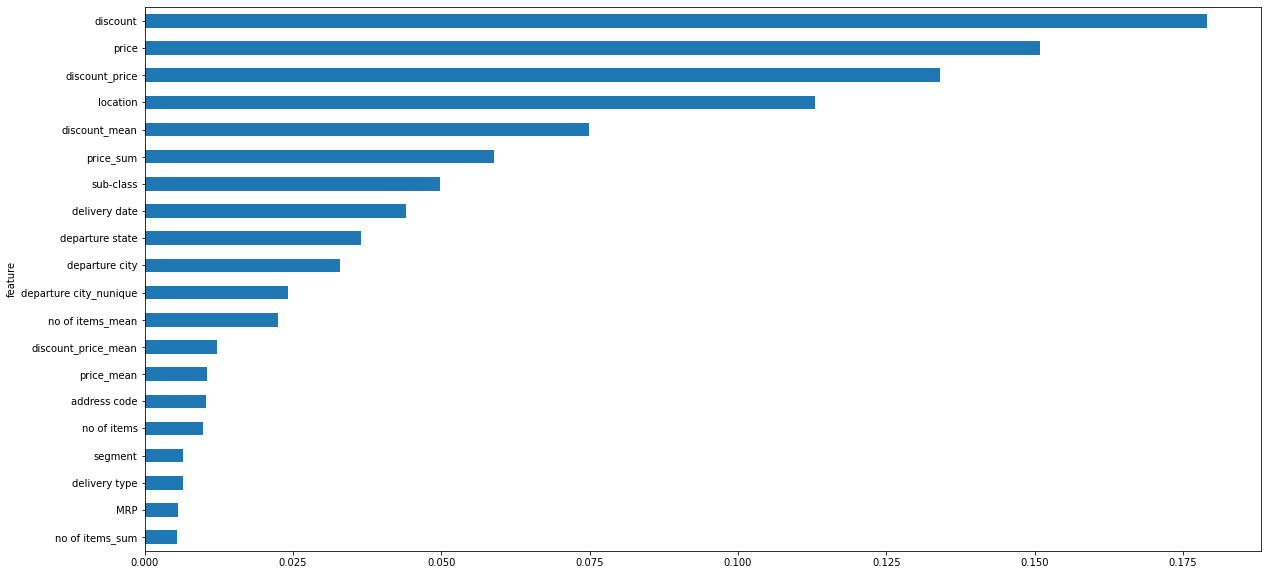

In [ ]:
xgb = XGBRegressor(n_estimators=800)

dtet_oofs, test_pred, feature_importance = run_clf_kfold(xgb, train_df, test_df, features)

**CatBoost**

In [ ]:
!pip install catboost

Streaming output truncated to the last 5000 lines.
8:	learn: 0.2049476	total: 28.2ms	remaining: 15.6s
9:	learn: 0.2236727	total: 30.4ms	remaining: 15.1s
10:	learn: 0.2395753	total: 32.5ms	remaining: 14.8s
11:	learn: 0.2568714	total: 34.9ms	remaining: 14.5s
12:	learn: 0.2724242	total: 37ms	remaining: 14.2s
13:	learn: 0.2889246	total: 39.3ms	remaining: 14s
14:	learn: 0.3012329	total: 41.5ms	remaining: 13.8s
15:	learn: 0.3189108	total: 43.7ms	remaining: 13.6s
16:	learn: 0.3341742	total: 46ms	remaining: 13.5s
17:	learn: 0.3498736	total: 48.2ms	remaining: 13.4s
18:	learn: 0.3632009	total: 50.4ms	remaining: 13.2s
19:	learn: 0.3770948	total: 52.6ms	remaining: 13.1s
20:	learn: 0.3901005	total: 54.7ms	remaining: 13s
21:	learn: 0.4023241	total: 57.1ms	remaining: 12.9s
22:	learn: 0.4154842	total: 59.3ms	remaining: 12.8s
23:	learn: 0.4290343	total: 61.7ms	remaining: 12.8s
24:	learn: 0.4405797	total: 64.1ms	remaining: 12.7s
25:	learn: 0.4521042	total: 66.2ms	remaining: 12.7s
26:	learn: 0.4624411	to

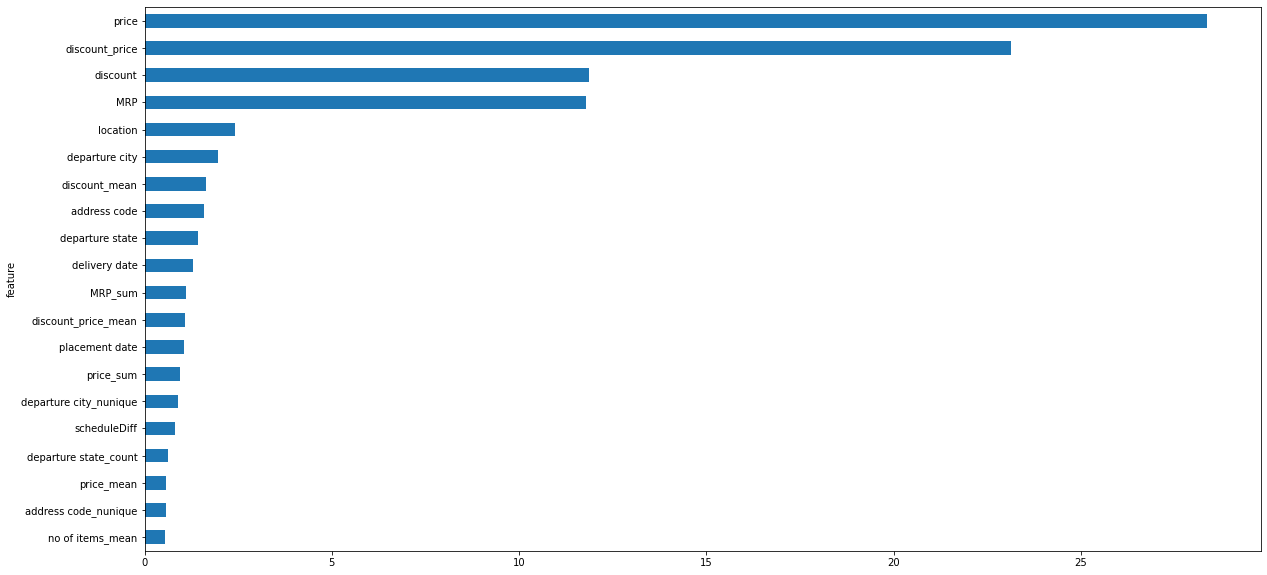

In [ ]:
from catboost import CatBoostRegressor
m = CatBoostRegressor(n_estimators=5000, random_state=1994, eval_metric='R2', learning_rate=0.03, max_depth=5)


dtet_oofs, test_pred, feature_importance = run_clf_kfold(m, train_df, test_df, features)
